# Intro

This file contains the code that shows the initial data exploration, training, and evaluation of the results. However, it does not show every aspect of the project because it was developed across multiple different files that were used for experimentation. 

Note that the training part will not work without the images, which are not a part of the GitHub repository! Images could not be redistributed.

# Initial data exploration

Check how many images there are for each diagnosis and characteristic, attempt simple classification of diagnosis based on cosine similarity and jaccard score.

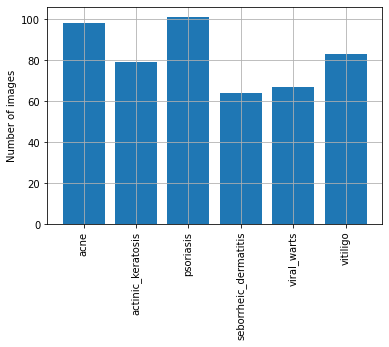

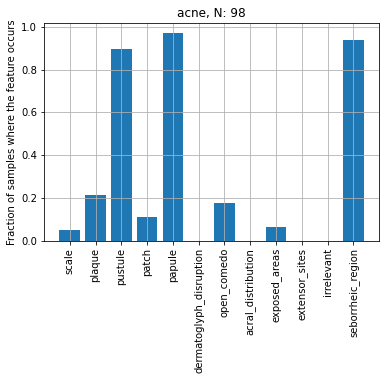

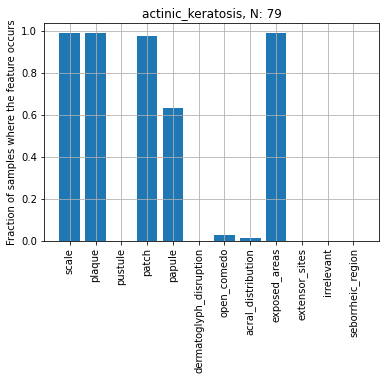

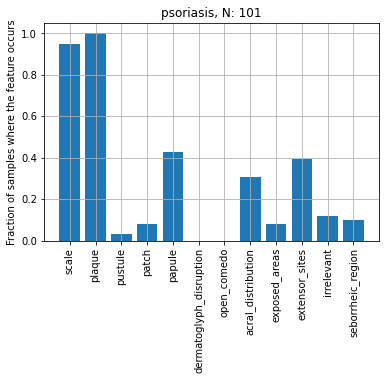

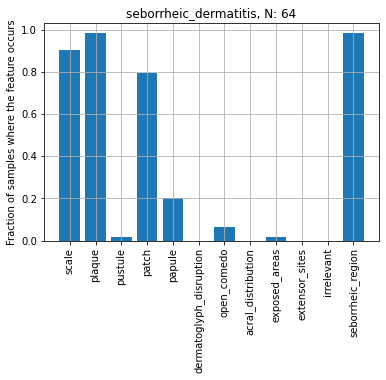

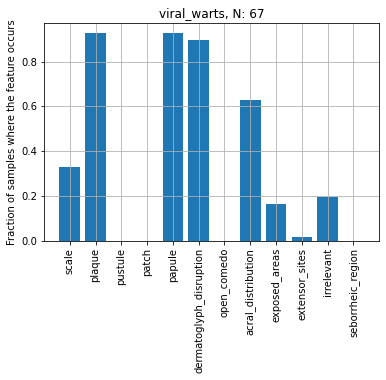

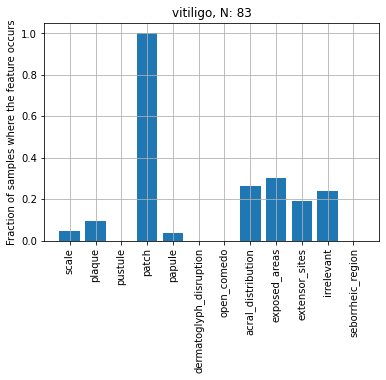

Text(0.5, 14.09375, 'Predicted')

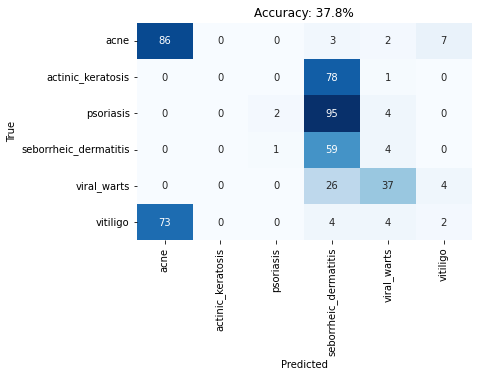

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

labels = pd.read_csv('dermx_labels.csv')
diseases_characteristics = pd.read_csv('diseases_characteristics.csv')

# Replace NaN with string "irrelevant"
labels['area'] = labels['area'].fillna('irrelevant')

diseases_characteristics = diseases_characteristics.rename(columns={'Unnamed: 0': 'disease'})

#%%
diagnosis = np.unique(labels['diagnosis'])
areas = np.unique(labels['area'])

data_stats = {}

for d in diagnosis:
    N = (labels['diagnosis']==d).sum()
    
    N_scale = ((labels['diagnosis']==d) & (labels['scale']==1)).sum()
    N_plaque = ((labels['diagnosis']==d) & (labels['plaque']==1)).sum()
    N_pustule = ((labels['diagnosis']==d) & (labels['pustule']==1)).sum()
    N_patch = ((labels['diagnosis']==d) & (labels['patch']==1)).sum()
    N_papule = ((labels['diagnosis']==d) & (labels['papule']==1)).sum()
    N_dermatoglyph_disruption = ((labels['diagnosis']==d) & (labels['dermatoglyph_disruption']==1)).sum()
    N_open_comedo = ((labels['diagnosis']==d) & (labels['open_comedo']==1)).sum()
    
    data_stats[d] = {'N':N, 'scale':N_scale/N, 'plaque':N_plaque/N, 'pustule':N_pustule/N,
                     'patch':N_patch/N,'papule':N_papule/N,'dermatoglyph_disruption':N_dermatoglyph_disruption/N,
                     'open_comedo':N_open_comedo/N}
    
    for a in areas:
        N_area = ((labels['diagnosis']==d) & (labels['area']==a)).sum()
        data_stats[d][a] = N_area/N

#%% Plot number of samples for each disease in the dataset
counts=[]
for i in range(len(diagnosis)):
    counts.append(data_stats[diagnosis[i]]['N'])

plt.bar(diagnosis,counts)
plt.ylabel('Number of images')
plt.title('')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#%% Plot feature distribution for each disease
for i in range(len(diagnosis)):
    
    #plt.subplot(len(diagnosis),1,i+1)
    bars = [*data_stats[diagnosis[i]].values()][1:]
    plt.bar([*data_stats[diagnosis[0]].keys()][1:],bars)
    plt.xticks(rotation=90)
    plt.title(f"{diagnosis[i]}, N: {data_stats[diagnosis[i]]['N']}")
    plt.ylabel('Fraction of samples where the feature occurs')
    plt.grid()
    plt.show()
    
#%% Try to classify the data using some simple metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

dc_np = diseases_characteristics.to_numpy()
data_np = labels.to_numpy()

pred_disease = np.empty(data_np.shape[0],dtype='object')

for i in range(data_np.shape[0]):
    
    sample_feature = data_np[i,2:-1]
    best_score = 0
    
    for j in range(dc_np.shape[0]):
        
        disease = dc_np[j,0]
        
        disease_feature = dc_np[j,1:-1]
        
        area_match = int(data_np[i,-1] == dc_np[j,-1])
        if data_np[i,-1]=='irrelevant':
            area_match = 1
            
        v1 = disease_feature.reshape(1,-1)
        v2 = sample_feature.reshape(1,-1)
        
        cs = cosine_similarity(v1,v2)
        # modify to enable jaccard score
        #js = jaccard_score(v1.astype(bool).flatten(),v2.astype(bool).flatten(),average='binary')
        if best_score<=cs:
            best_score=cs
            pred_disease[i] = disease
        
#%% Plot confusion matrix for the simple classification
from sklearn.metrics import confusion_matrix
import seaborn as sn

columns = [*np.unique(data_np[:,1])]

confm = confusion_matrix(data_np[:,1], pred_disease)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Blues', annot=True,cbar=False)
plt.title(f'Accuracy: {round(np.diag(confm).sum()/confm.sum()*100,2)}%')
plt.ylabel('True')
plt.xlabel('Predicted')

# Training
This part trains network multiple times for the variance evaluation. It will not work without data! Skip to the next section to see the results.

In [ ]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import copy
import time
from data_loader import Loader, splitData
import os
import pickle

IMG_PATH = "images/"
N_RUNS = 10
NUM_EPOCHS = 50

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomAffine(degrees=(-180,180),
                                                             translate=(0.1,0.1),
                                                             scale=(0.9,1.1),
                                                             shear=25),
                                      transforms.ColorJitter(brightness=0.05,
                                                             contrast=0.05,
                                                             saturation=0.05,
                                                             hue=0.05)
                                      ])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The model will run on: {device}')


class Model(torch.nn.Module):
    def __init__(self,num_diagnosis,num_characteristics,base_model = 'efficientnet'):
        super(Model,self).__init__()
        
        # Change the number next to model name to change size
        if base_model == 'densenet':
            model = models.densenet201(pretrained=True)
            model.classifier = torch.nn.Linear(model.classifier.in_features, num_diagnosis+num_characteristics)
        
        elif base_model == 'resnet':
            model = models.resnet34(pretrained=True)
            model.fc = torch.nn.Linear(model.fc.in_features, num_diagnosis+num_characteristics)
            
        elif base_model == 'efficientnet':
            model = models.efficientnet_b2(pretrained=True)
            model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_diagnosis+num_characteristics)
        else:
            raise Exception('base model not available')
        
        for param in model.parameters():
            param.requires_grad=True
        
        self.model = model
        self.num_diagnosis = num_diagnosis
        self.num_characteristics = num_characteristics
        
    def forward(self,x):
        
        y = self.model(x)
        diagnosis_enc = y[:,:self.num_diagnosis]
        characteristic_enc = y[:,self.num_diagnosis:]
        
        return diagnosis_enc, characteristic_enc

      
def lossFunction(y_hat,y,diagnosis_weight,characteristic_weight):
    
    def bce(y_hat,y,weights = characteristic_weight ):
        p = torch.nn.Sigmoid()(torch.clip(y_hat,-10,10))
        loss = -torch.mean(characteristic_weight*y*torch.log(p) + (1-characteristic_weight)*(1-y)*torch.log(1-p))
        return loss
    
    y_hat_diagnosis = y_hat[0]
    y_hat_characteristic = y_hat[1]
    y_diagnosis = y[0]
    y_characteristic = y[1]
        
    
    xEntropy = torch.nn.CrossEntropyLoss(weight=diagnosis_weight.to(device),reduce='mean')
    #bce = torch.nn.BCELoss(reduce='mean')
    sigmoid = torch.nn.Sigmoid()
    xEntropy_loss = xEntropy(y_hat_diagnosis,y_diagnosis)
    bce_loss = bce(y_hat_characteristic,y_characteristic)
    
    if bce_loss<0:
        print(sigmoid(y_hat_characteristic))
        print(y_characteristic)
        print(bce_loss)
    
    return xEntropy_loss, bce_loss

def train(model,train_set,test_set,lossFunction,optimizer,diagnosis_weight,characteristics_weight,
          num_epochs=10,batch_size=64,num_workers=16, save_path=None):
    
    history = {'train_loss':[],
               'train_diagnosis_loss':[],
               'train_characteristic_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_diagnosis_loss':[],
               'test_characteristic_loss':[],
               'test_accuracy':[]}
    
    N_train = len(train_set)
    N_test = len(test_set)
    
    train_loader = DataLoader(train_set,batch_size=batch_size,
                              shuffle=True,num_workers=num_workers)
    
    test_loader = DataLoader(test_set,batch_size=batch_size,
                              shuffle=False,num_workers=num_workers)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
    
    for epoch_idx in range(num_epochs):
        
        train_iterator = iter(train_loader)
        test_iterator = iter(test_loader)
                
        train_loss = 0
        train_diagnosis_loss = 0
        train_characteristic_loss = 0
        train_correct = 0
        
        test_loss = 0
        test_diagnosis_loss = 0
        test_characteristic_loss = 0
        test_correct = 0
        
        model.train()
        for img,disease,characteristic in tqdm(train_iterator, desc='train: '):
            X = img.to(device).float()
            y = [disease.to(device), characteristic.to(device)]
            
            curr_batch_size = disease.shape[0]
            
            optimizer.zero_grad()
            y_hat = model(X)
            xEntropy_loss, bce_loss = lossFunction(y_hat,y,diagnosis_weight,characteristics_weight)
            loss = xEntropy_loss + bce_loss
            loss.backward()
            optimizer.step()
            
            train_loss += curr_batch_size * loss / N_train
            train_diagnosis_loss += curr_batch_size * xEntropy_loss / N_train
            train_characteristic_loss += curr_batch_size * bce_loss / N_train
            
            predicted = y_hat[0].argmax(1)
            train_correct += (y[0]==predicted).sum().item()
        
        model.eval()
        for img,disease,characteristic in tqdm(test_iterator, desc='test: '):
            
            with torch.no_grad():
                X = img.to(device).float()
                y = [disease.to(device), characteristic.to(device)]
                
                curr_batch_size = disease.shape[0]
            
                y_hat = model(X)
                xEntropy_loss, bce_loss = lossFunction(y_hat,y,diagnosis_weight,characteristics_weight)
                loss = xEntropy_loss + bce_loss
            
                test_loss += curr_batch_size * loss / N_test
                test_diagnosis_loss += curr_batch_size * xEntropy_loss / N_test
                test_characteristic_loss += curr_batch_size * bce_loss / N_test
                
                predicted = y_hat[0].argmax(1)
                test_correct += (y[0]==predicted).sum().item()
            
        history['train_loss'].append(train_loss.item())
        history['train_diagnosis_loss'].append(train_diagnosis_loss.item())
        history['train_characteristic_loss'].append(train_characteristic_loss.item())
        history['train_accuracy'].append(train_correct/N_train)
        history['test_loss'].append(test_loss.item())
        history['test_diagnosis_loss'].append(test_diagnosis_loss.item())
        history['test_characteristic_loss'].append(test_characteristic_loss.item())
        history['test_accuracy'].append(test_correct/N_test)
        

        if save_path is not None and len(history['test_loss'])==1:
            torch.save(model,save_path)
        elif save_path is not None and history['test_loss'][-1]<np.min(history['test_loss'][:-1]):
            torch.save(model,save_path)
            print('Saved model with test loss: {}'.format(history['test_loss'][-1]))
        
    return history

#%%
data = Loader(img_size=[224,224],img_path=IMG_PATH)

RESULTS = {'test':[],'val':[]}

def evaluate(model,data):
    N = len(data)
    diagnosis_pred = np.zeros((N,6))
    char_pred = np.zeros((N,7))

    diagnosis_true = np.zeros(N)
    char_true = np.zeros_like(char_pred)

    for i in range(N):
        img,y,c=data[i]
        y_hat = model(img.view(1,3,224,224).to(device))
        y_hat_d = y_hat[0].cpu().detach().numpy()
        y = y.numpy()
        
        diagnosis_pred[i] = y_hat_d
        
        cp = torch.nn.Sigmoid()(y_hat[1]).cpu().detach().numpy()
        char_pred[i] =  cp
        
        diagnosis_true[i] = y
        char_true[i] = c.cpu().numpy()

    return diagnosis_true, char_true, diagnosis_pred, char_pred



# For each run, generate a different dataset. set random seed for data split to i
for i in range(N_RUNS):
    
    model = Model(6,7)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    
    train_set,test_set,val_set = splitData(data,0.6,0.2,0.2,seed=i)
    train_set.setTransform(train_transform)
    
    # Compute disease class weights
    diagnosis_train = list(np.unique(train_set.data['diagnosis']))
    diagnosis_count = torch.zeros(len(diagnosis_train))
    for i in range(len(diagnosis_train)):
        diagnosis_count[i] = (train_set.data['diagnosis']==diagnosis_train[i]).sum()

    diagnosis_frac = diagnosis_count/diagnosis_count.sum()
    diagnosis_weight = (1-diagnosis_frac)/(1-diagnosis_frac).sum()

    # Compute characteristic weights for unbalanced data
    idx=0
    characteristic_count = torch.zeros(7)
    for key in train_set.data.keys()[3:-1]:
        characteristic_count[idx] = (train_set.data[key]>0).sum()
        idx+=1
    characteristic_weight = (1-characteristic_count/len(train_set)).to(device)
    #characteristic_weight = (torch.ones(7)*0.5).to(device)
    characteristic_names = train_set.data.keys()[3:-1].tolist()
    
    
    # Train the model
    history = train(model,train_set,test_set,lossFunction,optimizer,diagnosis_weight,characteristic_weight,
                        num_epochs=NUM_EPOCHS,batch_size=16,num_workers=8,save_path='temp_net')
    
    # Load the best model
    model = torch.load('temp_net',map_location='cpu')
    model.eval()
    model.to(device)
    
    # Evaluate the model
    test_diag_true,test_char_true,test_diag_pred,test_char_pred = evaluate(model,test_set)
    val_diag_true,val_char_true,val_diag_pred,val_char_pred = evaluate(model,val_set)
    RESULTS['test'].append([test_diag_true,test_char_true,test_diag_pred,test_char_pred ])
    RESULTS['val'].append([val_diag_true,val_char_true,val_diag_pred,val_char_pred ])

    os.remove('temp_net')
    
# Save the evaluation file
with open('results_50ep_weighted.pickle','wb') as handle:
    pickle.dump(RESULTS,handle)

# Training results


Bayes Classifier (disease char. based) val score: 0.35320088300220753
Bayes Classifier (data based) val score: 0.8454746136865342


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Diagnosis Metric 

Diagnosis accuracy: 0.7860357248902942, std: 0.04407471905516767 

Precision
Acne: 	 0.8024,               std: 0.0611
Actinic Keratosis: 	 0.7891,               std: 0.1003
Psoriasis: 	 0.8247,               std: 0.1076
Seborrheic Dermatitis: 	 0.6976,               std: 0.1283
Viral Warts: 	 0.7214,               std: 0.1262
Vitiligo: 	 0.8746,               std: 0.0686


Recall
Acne: 	 0.8634,               std: 0.1065
Actinic Keratosis: 	 0.7159,               std: 0.0641
Psoriasis: 	 0.731,               std: 0.1118
Seborrheic Dermatitis: 	 0.7196,               std: 0.1121
Viral Warts: 	 0.8638,               std: 0.0433
Vitiligo: 	 0.8153,               std: 0.1037


F1 Score
Acne: 	 0.8285,               std: 0.072
Actinic Keratosis: 	 0.7471,               std: 0.0635
Psoriasis: 	 0.7637,               std: 0.0691
Seborrheic Dermatitis: 	 0.6993,               std: 0.101
Viral Warts: 	 0.7805,               std: 0.0813
Vitiligo: 	 0.8392,               std: 

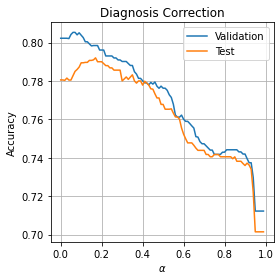

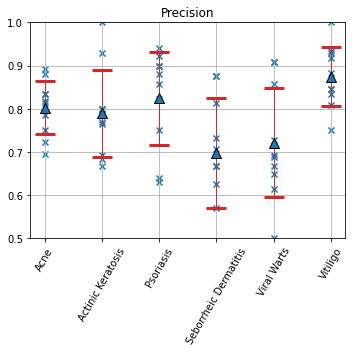

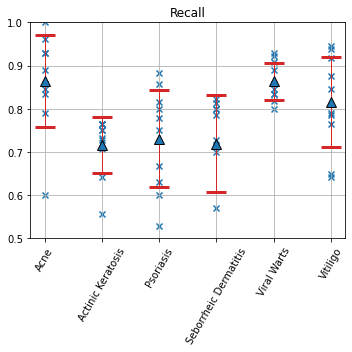

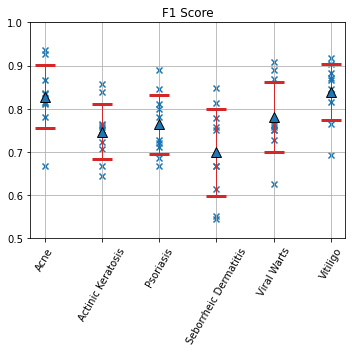

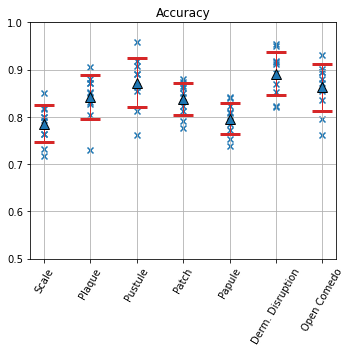

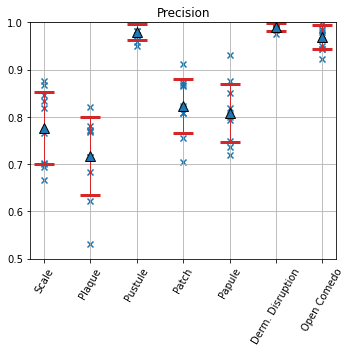

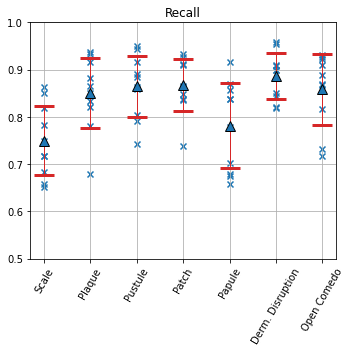

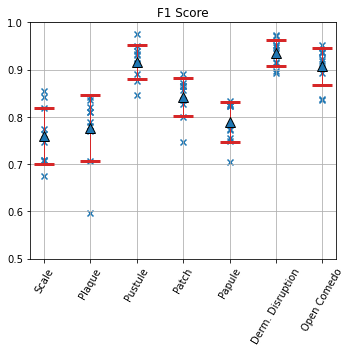

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle
import torch
from sklearn.naive_bayes import BernoulliNB
from data_loader import Loader
import pandas as pd


with open('results_50ep_weighted.pickle','rb') as handle:
    results = pickle.load(handle)
    
test_results = results['test']
val_results = results['val']

def diagnosisCorrection(diagnosis_pred,characteristic_pred,correction_dict):
    correction_model, alpha = correction_dict['model'], correction_dict['alpha']
    softmax = torch.nn.Softmax(dim=1)
    diagnosis_pred_softmax = softmax(torch.tensor(diagnosis_pred))
    diagnosis_pred_NB = correction_model.predict_proba(characteristic_pred>0.5)
    diagnosis_corr = softmax( (1-alpha) * diagnosis_pred_softmax + alpha * diagnosis_pred_NB )
    
    return diagnosis_corr

def getMetrics(true,pred):
    conf_mat = confusion_matrix(true,pred)
    acc= np.diag(conf_mat).sum()/conf_mat.sum()
    pre= np.diag(conf_mat) / conf_mat.sum(0)
    rec= np.diag(conf_mat) / conf_mat.sum(1)
    f1 = 2* pre*rec / (pre+rec)
    
    return acc,np.nan_to_num(pre,nan=0.0),np.nan_to_num(rec,nan=0.0),np.nan_to_num(f1,nan=0.0)

def processResults(results, correction_dict = None):
    diagnosis_metrics = []
    diagnosis_acc= []
    characteristic_metrics = []
    
    for result  in results:
    
        dt,ct,dp,cp = result
        
        if correction_dict is not None:
            dp = diagnosisCorrection(dp,cp,correction_dict)
        
        acc,pre,rec,f1 = getMetrics(dt,dp.argmax(1))
        diagnosis_acc.append(acc)
        diagnosis_metrics.append([pre,rec,f1])
        
        char = []
        for i in range(7):
            
            acc,pre,rec,f1 = getMetrics(ct[:,i],(cp>0.5)[:,i])
            char.append([acc,pre[0],rec[0],f1[0]])
        characteristic_metrics.append(np.array(char))
            
    diagnosis_acc = np.array(diagnosis_acc)
    diagnosis_metrics = np.array(diagnosis_metrics)
    characteristic_metrics = np.swapaxes(np.array(characteristic_metrics),1,2)
    
    return diagnosis_acc, diagnosis_metrics, characteristic_metrics

#%% Fit a bernoulli naive bayes model to use for diagnosis correction

train_np = Loader(img_size=[224,224],img_path=None).data.to_numpy()[:,1:-1]
train_np[:,-1] = np.clip(train_np[:,-1], 0, 1) # The last value should be between 0 and 1, not 0 and 8

disease_characteristics_np = pd.read_csv('diseases_characteristics_sorted.csv',delimiter=',').to_numpy()

modelNB_dc = BernoulliNB()
modelNB_dc.fit(disease_characteristics_np[:,1:-1],disease_characteristics_np[:,0])
print(f'Bayes Classifier (disease char. based) val score: {modelNB_dc.score(train_np[:,1:],train_np[:,0])}')

modelNB = BernoulliNB()
modelNB.fit(train_np[:,1:],train_np[:,0])
print(f'Bayes Classifier (data based) val score: {modelNB.score(train_np[:,1:],train_np[:,0])}')

correction_dict = {'model':modelNB,'alpha':0}

#%% Choose the best alpha parameter to combine predicted diagnosis and correction
As = np.arange(0,1,0.01)
accuracies_test = np.zeros((len(As),10))
accuracies_val = np.zeros((len(As),10))
i=0

for a in As:
    correction_dict['alpha']=a

    diagnosis_acc_test, _,_= processResults(test_results, correction_dict=correction_dict)
    diagnosis_acc_val, _,_= processResults(val_results, correction_dict=correction_dict)
    accuracies_test[i]=diagnosis_acc_test
    accuracies_val[i]=diagnosis_acc_val
    i+=1
    
plt.figure(figsize=(4,4))
plt.plot(As,accuracies_test.mean(1),label='Validation') 
plt.plot(As,accuracies_val.mean(1),label='Test')
plt.grid()
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')
plt.title('Diagnosis Correction')
plt.legend()
plt.tight_layout()
#plt.ylim([0.5,1])
plt.savefig('figures/diagnosis_correction.eps')


#%%
correction_dict['alpha'] = As[np.argmax(accuracies_test.mean(0))]
diagnosis_acc, diagnosis_metrics, characteristic_metrics = processResults(val_results, correction_dict=correction_dict)


#%% Plot
diagnosis_str = np.array(['Acne','Actinic Keratosis','Psoriasis','Seborrheic Dermatitis','Viral Warts','Vitiligo'])
characteristic_str = ['Scale','Plaque','Pustule','Patch','Papule','Derm. Disruption','Open Comedo']
metric_str = ['Accuracy','Precision','Recall','F1 Score']

print('Diagnosis Metric \n')
print(f'Diagnosis accuracy: {diagnosis_acc.mean()}, std: {diagnosis_acc.std()} \n')

for i in range(1,4,1):
    print(f'{metric_str[i]}')
    for j in range(6):
        print(f'{diagnosis_str[j]}: \t {np.round(diagnosis_metrics[:,i-1,j].mean(0),4)}, \
              std: {np.round(diagnosis_metrics[:,i-1,j].std(0),4)}')
    print('\n')
    

print('Characteristic metrics \n')
for i in range(0,4,1):
    print(f'{metric_str[i]}')
    for j in range(7):
        print(f'{characteristic_str[j]}: \t {np.round(characteristic_metrics[:,i,j].mean(0),4)},  \
              std: {np.round(characteristic_metrics[:,i,j].std(0),4)}')
    print('\n')

#%%

errbar_dict = {'marker':'^','fmt':' ','mec':'k','ms':10,'capsize':10,
               'capthick':3,'ecolor':'tab:Red','elinewidth':1}

for i in range(1,4,1):

    plt.figure(figsize=(5,5))
    plt.errorbar(diagnosis_str, diagnosis_metrics[:,i-1,:].mean(0),diagnosis_metrics[:,i-1,:].std(0),**errbar_dict)
    for j in range(len(diagnosis_str)):
        plt.scatter([diagnosis_str[j]]*diagnosis_metrics.shape[0],diagnosis_metrics[:,i-1,j],
                    marker='x',color='tab:Blue')        
    plt.xticks(rotation=60)
    plt.title(metric_str[i])
    plt.grid()
    plt.ylim([0.5,1])
    plt.tight_layout()
    plt.savefig(f'figures/diagnosis_{metric_str[i]}.eps')

#%%
for i in range(0,4,1):

    plt.figure(figsize=(5,5))
    plt.errorbar(characteristic_str, characteristic_metrics[:,i,:].mean(0),characteristic_metrics[:,i,:].std(0),**errbar_dict)
    for j in range(len(characteristic_str)):
        plt.scatter([characteristic_str[j]]*characteristic_metrics.shape[0],characteristic_metrics[:,i,j],
                    marker='x',color='tab:Blue')
    plt.xticks(rotation=60)
    plt.title(metric_str[i])
    plt.grid()
    plt.ylim([0.5,1])
    plt.tight_layout()
    plt.savefig(f'figures/characteristics_{metric_str[i]}.eps')